In [1]:
%load_ext autoreload

%autoreload 2

import utils
import numpy as np
import seaborn as sns
from matplotlib import cm as cmaps
import pandas as pd
from scipy.stats import zscore, sem, pearsonr
from sklearn import linear_model, mixture, cluster
import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import ttest_ind
from sklearn.preprocessing import PolynomialFeatures
import itertools
pd.options.mode.chained_assignment = None

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

%run -i 'helperFiles/style_script.py'
color = colors[1]

/home/lu/anaconda3/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
def moving_average(xs, dt):
    if dt == 0:
        return xs
    av_xs = np.zeros((xs.shape[0], xs.shape[1]))
    for i, x in enumerate(xs):
        av_xs[i] = np.convolve(x, np.ones(dt), 'same') / dt
    return av_xs

def pearsonr_pval(x,y):
        return pearsonr(x,y)[1]

# Load Data

Text(0.5, 45.42881944444444, 'bet size')

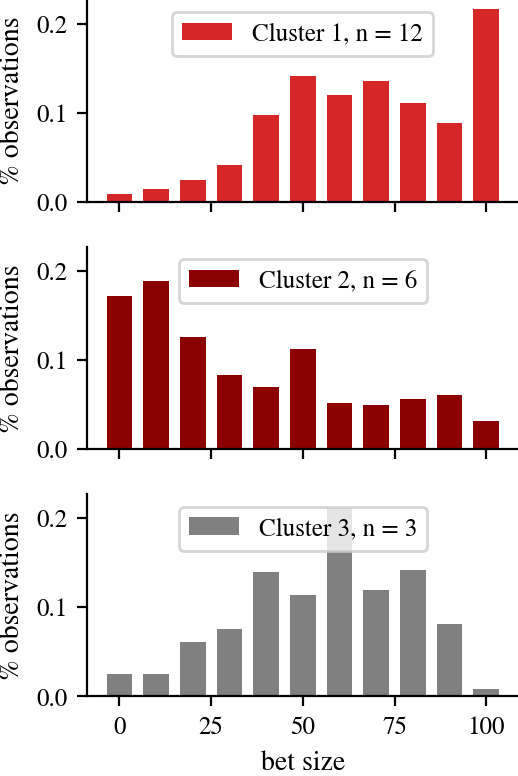

In [3]:
preds = np.load('data/clusters_patients.npy')
data = utils.load_data_patient('all')
all_data = pd.DataFrame()

for i, subject in enumerate(data):
    subject['subj'] = i
    subject['cluster'] = preds[i]
    all_data = pd.concat([all_data, subject])
all_data.index = np.arange(len(all_data))
all_data0 = all_data[all_data['cluster']==0]
all_data1 = all_data[all_data['cluster']==1]
np.random.seed(111)

bet_data = pd.crosstab(all_data['subj'], all_data['bet'])



n = len(np.unique(preds))
fig, ax = plt.subplots(n,1, figsize=(figwidth/2,4), dpi=200, sharey=True, sharex=True)

for i in range(n):

    ax[i].bar(np.arange(0,101,10), bet_data[preds==i].sum(axis=0)/bet_data[preds==i].sum().sum(), width=7, color=(color)[i])
    ax[i].legend(['Cluster %d, n = %d' % (i+1, (preds==i).sum())], loc='upper center')
    ax[i].set_ylabel('% observations')

plt.tight_layout()
plt.xlabel('bet size')

# 2016 Kishida

FileNotFoundError: [Errno 2] No such file or directory: '/home/lu/Documents/DayanLab/SequentialInvestmentTask/data/Bubble/Neurochemistry/'

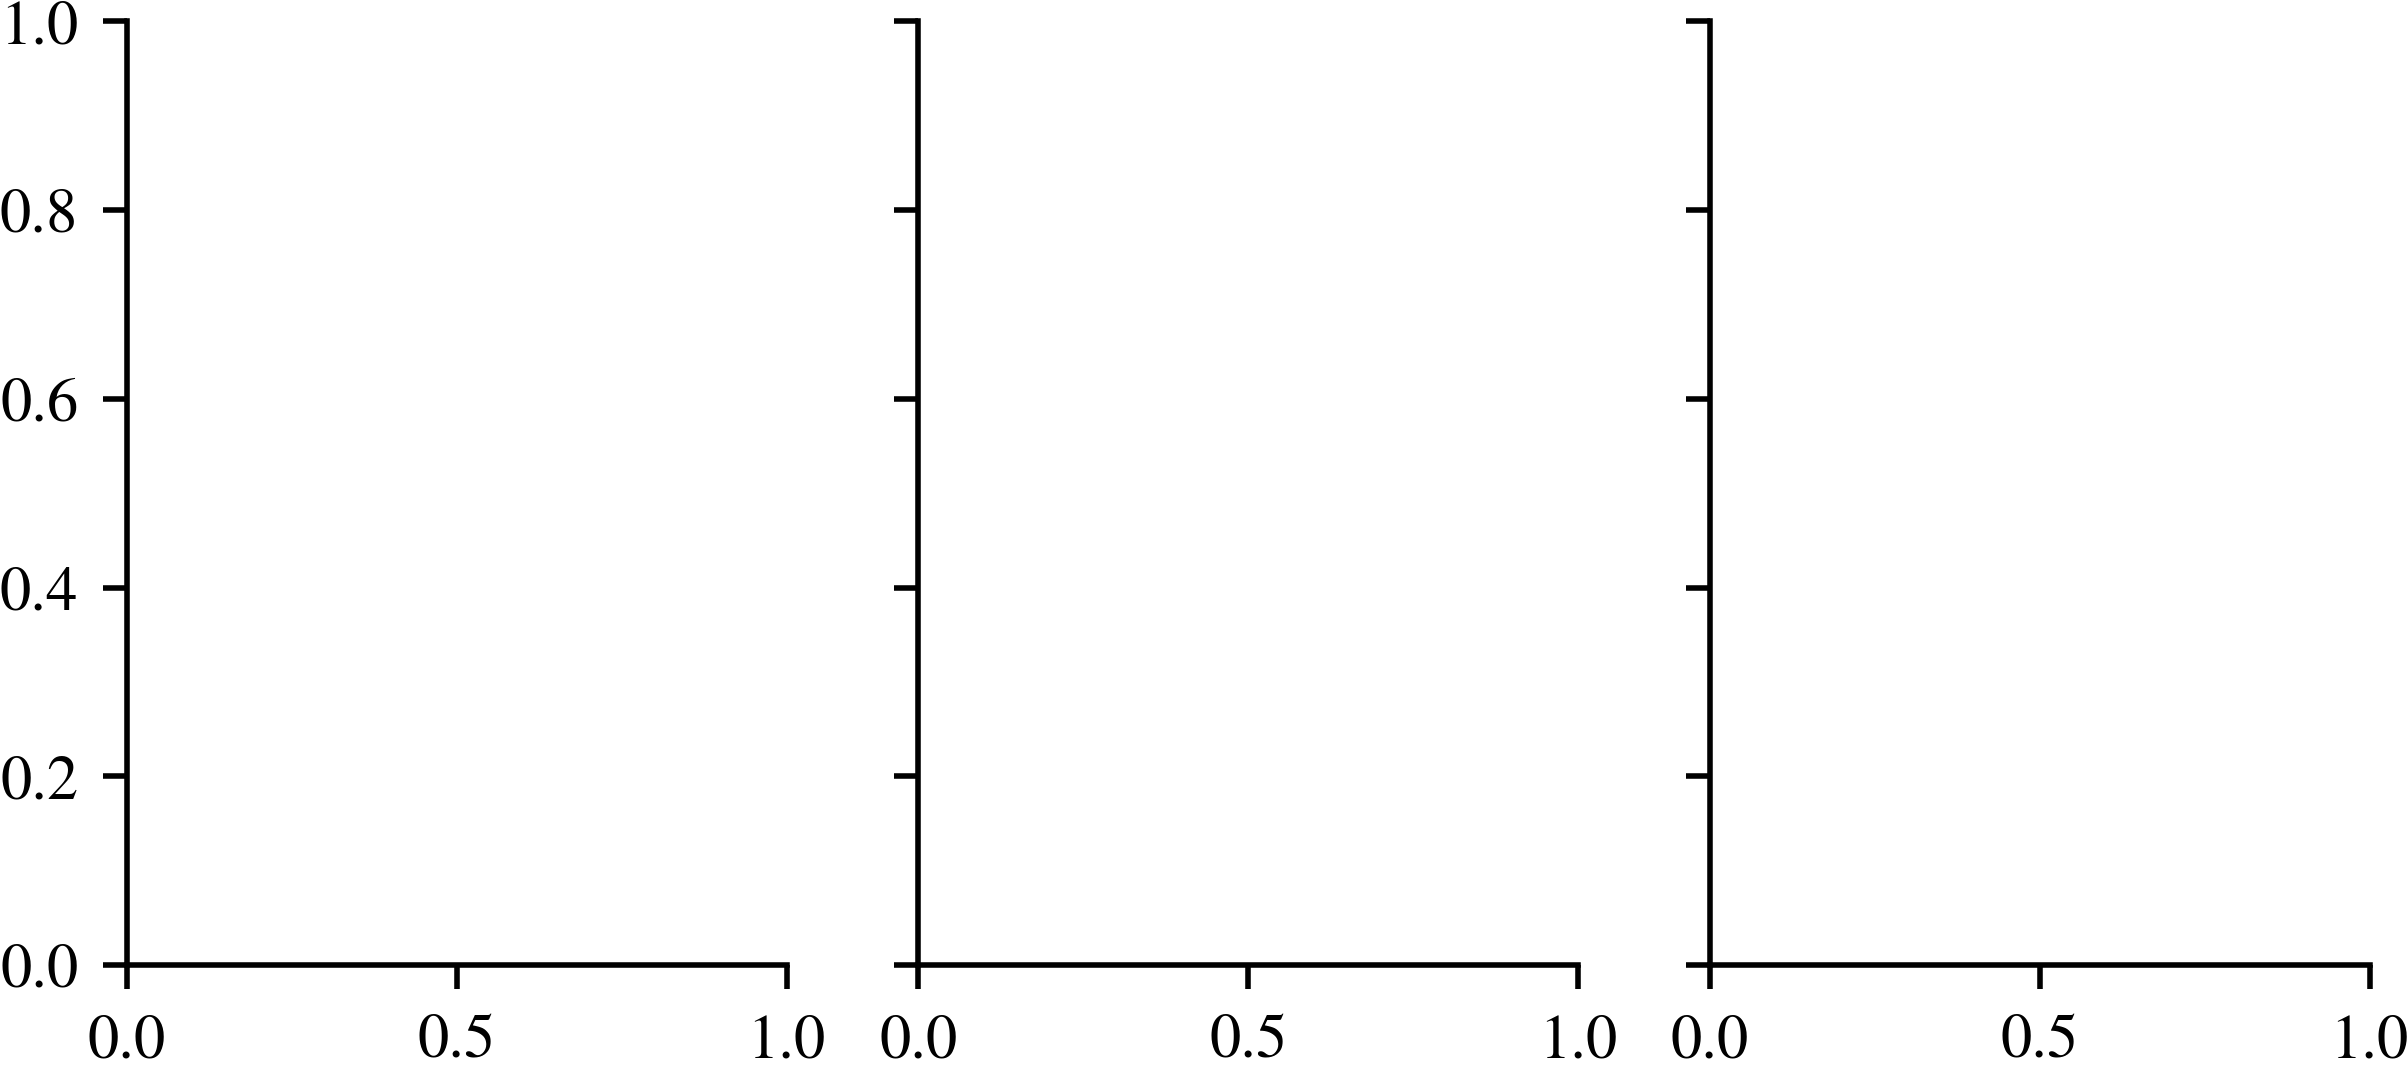

In [4]:
dt = 5

xlim=(0,1.2)
# x = np.linspace(-30+(dt-1)/2,30-(dt-1)/2,61-(dt-1))/10
x = np.linspace(-30,30,61)/10
x_raw = x[np.argmin(abs(x-xlim[0])):np.argmin(abs(x-xlim[1]))+1]
x_plot = x[np.argmin(abs(x-xlim[0])):np.argmin(abs(x-xlim[1]))+1]

nt = 'da'

behav_data = utils.load_data_patient('all')


fig, axs = plt.subplots(1,3, figsize=(figwidth, 2.5), dpi=500, sharex=True, sharey=True)

ranges = [[10,60], [60, 90], [90, np.inf]]
titles = ['lower bets', 'medium bets', 'higher bets']

neural_data =  utils.load_data_neural('all', neurotransmitter=nt, event='reveal')

for j, range_ in enumerate(ranges):

    pos_out = np.empty((0,61))
    neg_out = np.empty((0,61))

    for s, (neural, behav) in enumerate(zip(neural_data, behav_data)):

        crit_pos = (behav['bet']<range_[1]) & (behav['bet']>=range_[0]) & (behav['actual']>+0) & (behav['d_market']>0)
        crit_neg = (behav['bet']<range_[1]) & (behav['bet']>=range_[0]) & (behav['actual']<-0) & (behav['d_market']<0)

        pos_out = np.vstack((pos_out, neural[:len(behav)][crit_pos]))
        neg_out = np.vstack((neg_out, neural[:len(behav)][crit_neg]))

    pos_out = pos_out[~np.any(np.isnan(pos_out),axis=1)]
    neg_out = neg_out[~np.any(np.isnan(neg_out),axis=1)]

    pos_out = pos_out[:, np.argmin(abs(x-xlim[0])):np.argmin(abs(x-xlim[1]))+1]
    neg_out = neg_out[:, np.argmin(abs(x-xlim[0])):np.argmin(abs(x-xlim[1]))+1]

    standard_pos_out = zscore(pos_out, axis=1)
    standard_neg_out = zscore(neg_out, axis=1)
    
    av_pos_out = moving_average(standard_pos_out, dt=dt)
    av_neg_out = moving_average(standard_neg_out, dt=dt)

    mean_pos = np.nanmean(av_pos_out, axis=0)-np.nanmean(av_pos_out[:,np.argwhere(x_plot==0)])
    mean_neg = np.nanmean(av_neg_out, axis=0)-np.nanmean(av_neg_out[:,np.argwhere(x_plot==0)])

    sem_pos = sem(av_pos_out, axis=0)
    sem_neg = sem(av_neg_out, axis=0)

    pos = standard_pos_out-np.nanmean(standard_pos_out[:,np.argwhere(x_raw==0)])
    neg = standard_neg_out-np.nanmean(standard_neg_out[:,np.argwhere(x_raw==0)])
    
    signif = ttest_ind(pos,neg)[1]
    signif_corr = fdrcorrection(signif)[0]
    
    axs[j].plot(x_plot, mean_pos, 'tab:green', label='$N=%d$' % len(pos_out))
    axs[j].fill_between(x_plot, mean_pos-sem_pos, mean_pos+sem_pos, alpha=.4, color='tab:green')
    axs[j].plot(x_plot, mean_neg, 'tab:red', label='$N=%d$' % len(neg_out))
    axs[j].fill_between(x_plot, mean_neg-sem_neg, mean_neg+sem_neg, alpha=.4, color='tab:red')
    axs[j].legend(fontsize=9, loc='lower left', frameon=False, handlelength=.5)
    
    if j == 0:
        axs[j].set_ylabel('dopamine concentration (z-scored)')
    else:
        axs[j].get_yaxis().set_visible(False)
        axs[j].spines['left'].set_visible(False)
    axs[j].set_title(titles[j])
    
    print(titles[j] + ' - Signif. ts :' + str(x_plot[signif_corr]))
    
    for x_sig in x_plot[signif_corr]:
        axs[j].text(x_sig, .15, '*',va='top', ha='center', fontsize=9)

    axs[j].set_ylim(-.25,top=.15)
    
plt.xlim(-.1)
axs[1].set_xlabel('t (s)')
axs[2].axhline(y=0, xmin=-2.25, xmax=1,c="gray", linewidth=.8, zorder=-1, clip_on=False)
fig.legend(['$actual > 0$', '$actual < 0$'], fontsize=10, frameon=False, loc=7, handlelength=.5)
plt.tight_layout()
fig.subplots_adjust(right=0.83) 
plt.savefig('figures/replication_2016.pdf')
plt.savefig('figures/replication_2016.png')

In [ ]:
dt = 5

xlim=(0,1.2)
x = np.linspace(-30,30,61)/10
x_plot = x[np.argmin(abs(x-xlim[0])):np.argmin(abs(x-xlim[1]))+1]

nt = 'da'
n_bins=3
ranges = [[0,30], [30, 60], [60, 90], [90,np.inf]]
behav_data = utils.load_data_patient('all')

fig, axs = plt.subplots(2,len(ranges), figsize=(figwidth, 4), dpi=500, sharex=True, sharey='row')

titles = ['$0-20\%$', '$30-50\%$', '$60-80\%$', '$90-100\%$']

neural_data =  utils.load_data_neural('all', neurotransmitter=nt, event='reveal')

for cluster, data in zip([0,1], [all_data0, all_data1]):
    
    for j, range_ in enumerate(ranges):

        pos_out = np.empty((0,61))
        neg_out = np.empty((0,61))

        for s, (neural, behav) in enumerate(zip(neural_data, behav_data)):

            if not preds[s]==cluster:
                continue

            crit_pos = (behav['bet']<range_[1]) & (behav['bet']>=range_[0]) & (behav['actual']>+0) & (behav['d_market']>0)
            crit_neg = (behav['bet']<range_[1]) & (behav['bet']>=range_[0]) & (behav['actual']<-0) & (behav['d_market']<0)

            pos_out = np.vstack((pos_out, neural[:len(behav)][crit_pos]))
            neg_out = np.vstack((neg_out, neural[:len(behav)][crit_neg]))

        pos_out = pos_out[~np.any(np.isnan(pos_out),axis=1)]
        neg_out = neg_out[~np.any(np.isnan(neg_out),axis=1)]

        pos_out = pos_out[:, np.argmin(abs(x-xlim[0])):np.argmin(abs(x-xlim[1]))+1]
        neg_out = neg_out[:, np.argmin(abs(x-xlim[0])):np.argmin(abs(x-xlim[1]))+1]

        standard_pos_out = zscore(pos_out, axis=1)
        standard_neg_out = zscore(neg_out, axis=1)

        av_pos_out = moving_average(standard_pos_out, dt=dt)
        av_neg_out = moving_average(standard_neg_out, dt=dt)

        mean_pos = np.nanmean(av_pos_out, axis=0)-np.nanmean(av_pos_out[:,np.argwhere(x_plot==0)])
        mean_neg = np.nanmean(av_neg_out, axis=0)-np.nanmean(av_neg_out[:,np.argwhere(x_plot==0)])

        sem_pos = sem(av_pos_out, axis=0)
        sem_neg = sem(av_neg_out, axis=0)

        pos = standard_pos_out-np.nanmean(standard_pos_out[:,np.argwhere(x_plot==0)])
        neg = standard_neg_out-np.nanmean(standard_neg_out[:,np.argwhere(x_plot==0)])

        signif = ttest_ind(pos,neg)[1]
        signif_corr = fdrcorrection(signif)[0]

        axs[cluster, j].plot(x_plot, mean_pos, 'tab:green', label='$N=%d$' % len(pos_out))
        axs[cluster, j].fill_between(x_plot, mean_pos-sem_pos, mean_pos+sem_pos, alpha=.4, color='tab:green')
        axs[cluster, j].plot(x_plot, mean_neg, 'tab:red', label='$N=%d$' % len(neg_out))
        axs[cluster, j].fill_between(x_plot, mean_neg-sem_neg, mean_neg+sem_neg, alpha=.4, color='tab:red')
        axs[cluster, j].legend(fontsize=9, loc='lower left', frameon=False, handlelength=.5)
#         axs[cluster, j].despine()
        if j == 0:
            axs[cluster, j].text(-.8,.5, 'C' + str(cluster+1), fontsize=fontsize, va='center', rotation=0, transform=axs[cluster, j].transAxes)
        else:
            axs[cluster, j].get_yaxis().set_visible(False)
            axs[cluster, j].spines['left'].set_visible(False)
        if cluster==0:
            axs[cluster, j].set_title(titles[j])
#         axs[cluster, j].plot(0, -.1, 'gray', marker='^', markeredgecolor='k')

        if cluster==0:
            axs[cluster, j].set_ylim(-.3,top=.2)
            for x_sig in x_plot[signif_corr]:
                axs[cluster, j].text(x_sig, .2, '*',va='top', ha='center', fontsize=9)  
        else:
            axs[cluster, j].set_ylim(-.7,top=.3)
            for x_sig in x_plot[signif_corr]:
                axs[cluster, j].text(x_sig, .3, '*',va='top', ha='center', fontsize=9)  
            
    axs[cluster,3].axhline(y=0, xmin=-3.1, xmax=0.96, c="gray", linewidth=.8, zorder=-1, clip_on=False)
    
plt.xlim(-.1)
fig.text(.48,-.02,'t (s)', fontsize=fontsize)
fig.text(.07,.5,'dopamine concentration (z-scored)', rotation=90, va='center', fontsize=11)
fig.legend(['$actual > 0$', '$actual < 0$'], fontsize=10, frameon=False, loc=7, handlelength=.5)
plt.tight_layout()
fig.subplots_adjust(right=0.83, wspace=.03) 
plt.savefig('figures/replication_2016_cluster.pdf')
plt.savefig('figures/replication_2016_cluster.png')

# 2018 Moran

In [ ]:
dt = 5
x = np.linspace(-30,30,61)/10
xlim = [0,.8]
x_plot = x[np.argmin(abs(x-xlim[0])):np.argmin(abs(x-xlim[1]))+1]

behav_data = utils.load_data_patient('all')

bet_bins = [[-5, 25], [25, 45], [45, 65], [65, 85], [85, 105]]

y_labels=['0-20%', '30-40%', '50-60%', '70-80%', '90-100%']
nt = 'se'

plt_colors = ['tab:orange', 'slategrey']
   
fig, axs = plt.subplots(1, len(bet_bins),figsize=(figwidth, 2.2), dpi=1000, sharex=True, sharey='row')
    
for j, bets in enumerate(bet_bins):

    neural_data =  utils.load_data_neural('all', neurotransmitter=nt, event='reveal')
    pos = np.empty((0,61))
    neg = np.empty((0,61))

    for s, (neural, behav) in enumerate(zip(neural_data, behav_data)):
        crit1 = neural[:len(behav)][(behav['d_bet']>=0) & (behav['bet']>bets[0]) & (behav['bet']<bets[1]) & (behav['actual']<0)]
        crit2 = neural[:len(behav)][(behav['d_bet']<0) & (behav['bet']>bets[0]) & (behav['bet']<bets[1]) & (behav['actual']<0)]
        pos = np.vstack((pos, crit1))
        neg = np.vstack((neg, crit2))

    pos = pos[~np.any(np.isnan(pos),axis=1)]
    neg = neg[~np.any(np.isnan(neg),axis=1)]

    signif_dat = []
    for dat, dat_type, col in zip([pos, neg], ['pos', 'neg'], plt_colors):
        if len(dat)==0:
            continue

        dat = dat[:, np.argmin(abs(x-xlim[0])):np.argmin(abs(x-xlim[1]))+1]
        standard_dat = zscore(dat, axis=1)
        av_dat = moving_average(standard_dat, dt=dt)
        mean_dat = np.nanmean(standard_dat, axis=0)-np.nanmean(standard_dat[:,np.argwhere(x_plot==0)])
        sem_dat = sem(standard_dat, axis=0)

        axs[j].plot(x_plot,mean_dat, col, label='$N=%d$' % len(dat))
        axs[j].fill_between(x_plot, mean_dat-sem_dat, mean_dat+sem_dat, alpha=.2, color=col, label=None)


        dat_ = standard_dat-np.nanmean(standard_dat[:,np.argwhere(x_plot==0)])
        signif_dat.append(dat_)

    axs[j].legend(fontsize=8, loc='lower left', frameon=False, handlelength=.5)

    signif = ttest_ind(signif_dat[0],signif_dat[1])[1]
    signif_corr= fdrcorrection(signif)[0]

    for x_sig in x_plot[signif_corr]:
        axs[j].text(x_sig, .5, '*',va='top', ha='center', fontsize=9)  

    axs[j].set_ylim(-1.3, .5)


    axs[j].set_title(y_labels[j], fontsize=8)
    if j==0:
        axs[j].set_ylabel('5-HT concentration (z-scored)')
        position = axs[j].get_position().x0
    else:
        axs[j].get_yaxis().set_visible(False)
        axs[j].spines['left'].set_visible(False)


    if j == len(bet_bins)-1:
        axs[j].axhline(y=0, xmin=-4.7, xmax=1, c="gray", linewidth=.8, zorder=-1, clip_on=False)

plt.xlim(-.1)
axs[2].set_xlabel('t (s)')
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles,['$\Delta b_{t} \geq 0$', '$\Delta b_{t} < 0$'], fontsize=10, frameon=False, loc=7, handlelength=.5, title='$actual<0$')

plt.tight_layout()
fig.subplots_adjust(right=0.86) 
plt.savefig('figures/replication_2018.pdf')
plt.savefig('figures/replication_2018.png')

In [ ]:
print('d_portfolio < 0')
dt = 5
x = np.linspace(-30,30,61)/10
xlim = [0,.8]
x_plot = x[np.argmin(abs(x-xlim[0])):np.argmin(abs(x-xlim[1]))+1]

behav_data = utils.load_data_patient('all')

bet_bins = [[-5, 25], [25, 45], [45, 65], [65, 85], [85, 105]]

y_labels=['0-20%', '30-40%', '50-60%', '70-80%', '90-100%']
nt = 'se'

plt_colors = ['tab:orange', 'slategrey']
   
fig, axs = plt.subplots(2, len(bet_bins),figsize=(figwidth, 4), dpi=1000, sharex=True, sharey='row')
    
for j, bets in enumerate(bet_bins):

    for cluster in [0,1]:
        neural_data =  utils.load_data_neural('all', neurotransmitter=nt, event='reveal')
        pos = np.empty((0,61))
        neg = np.empty((0,61))

        for s, (neural, behav) in enumerate(zip(neural_data, behav_data)):
            if not preds[s]==cluster:
                continue
            crit1 = neural[:len(behav)][(behav['d_bet']>=0) & (behav['bet']>bets[0]) & (behav['bet']<bets[1]) & (behav['actual']<0)]
            crit2 = neural[:len(behav)][(behav['d_bet']<0) & (behav['bet']>bets[0]) & (behav['bet']<bets[1]) & (behav['actual']<0)]
            pos = np.vstack((pos, crit1))
            neg = np.vstack((neg, crit2))
        
        pos = pos[~np.any(np.isnan(pos),axis=1)]
        neg = neg[~np.any(np.isnan(neg),axis=1)]
        
        signif_dat = []
        for dat, dat_type, col in zip([pos, neg], ['pos', 'neg'], plt_colors):
            if len(dat)==0:
                continue
            
            dat = dat[:, np.argmin(abs(x-xlim[0])):np.argmin(abs(x-xlim[1]))+1]
            standard_dat = zscore(dat, axis=1)
            av_dat = moving_average(standard_dat, dt=dt)
            mean_dat = np.nanmean(standard_dat, axis=0)-np.nanmean(standard_dat[:,np.argwhere(x_plot==0)])
            sem_dat = sem(standard_dat, axis=0)
            
            axs[cluster, j].plot(x_plot,mean_dat, col, label='$N=%d$' % len(dat))
            axs[cluster, j].fill_between(x_plot, mean_dat-sem_dat, mean_dat+sem_dat, alpha=.2, color=col, label=None)
            
            dat_ = standard_dat-np.nanmean(standard_dat[:,np.argwhere(x_plot==0)])
            signif_dat.append(dat_)
        
        
        axs[cluster, j].legend(fontsize=8, loc='lower left', frameon=False, handlelength=.5)
        
        if len(signif_dat) == 2:
            signif = ttest_ind(signif_dat[0],signif_dat[1])[1]
            signif_corr= fdrcorrection(signif)[0]

            for x_sig in x_plot[signif_corr]:
                axs[cluster, j].text(x_sig, 1, '*',va='top', ha='center', fontsize=9)  
                
        if cluster==0:
            axs[cluster, j].set_title(y_labels[j], fontsize=8)
            axs[cluster, j].set_ylim(-2, 1)
        else:
            axs[cluster, j].set_ylim(-2.2, 1)
        
        if j == 0:
            axs[cluster, j].text(-1.1,.5, 'C' + str(cluster+1), fontsize=fontsize, va='center', rotation=0, transform=axs[cluster, j].transAxes)
        else:
            axs[cluster, j].get_yaxis().set_visible(False)
            axs[cluster, j].spines['left'].set_visible(False)

        if j == len(bet_bins)-1:
            axs[0, j].axhline(y=0, xmin=-4.7, xmax=1, c="gray", linewidth=.8, zorder=-1, clip_on=False)
            axs[1, j].axhline(y=0, xmin=-4.7, xmax=1, c="gray", linewidth=.8, zorder=-1, clip_on=False)

fig.text(0.1,.5,'5-HT concentration (z-scored)', va='center', rotation=90, fontsize=fontsize)
plt.xlim(-0.1)
axs[1,2].set_xlabel('t (s)')
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles,['$\Delta b_{t} \geq 0$', '$\Delta b_{t} < 0$'], fontsize=10, frameon=False, loc=7, handlelength=.5, title='$actual<0$')
plt.tight_layout()
fig.subplots_adjust(right=0.86) 
plt.savefig('figures/replication_2018_clusters.pdf')
plt.savefig('figures/replication_2018_clusters.png')

# Regression analysis

In [8]:
def run_model(data, dep_var, regressors, degree=3, criterion=lambda x:True):
    poly = PolynomialFeatures(degree=degree, interaction_only=True, include_bias=False)
    data = data.dropna()
    Xb = data[regressors]
    y_true = data[dep_var].values
    X_tr = poly.fit_transform(Xb)
    cs = poly.get_feature_names()

    for j, c in enumerate(cs[:len(regressors)]):
        cs = [x.replace(c, regressors[j]) for x in cs]
        cs = [x.replace(' ', '*') for x in cs]
        rel_cs = [x for x in cs if criterion(x)]
    Xt = pd.DataFrame(X_tr,columns=cs)[rel_cs]
    mod = sm.OLS(y_true, Xt)
    result = mod.fit()
    return result


def shuffle_column(data, dep_var, regressors, shuffle_column, n=100, degree=3, criterion=lambda x:True):
    lls = []
    data = data.dropna()
    for i in range(n):
        dat = data.copy()
        dat[shuffle_column] = np.random.permutation(dat[shuffle_column])
        result = run_model(dat, dep_var, regressors, degree, criterion)
        lls.append(result.llf)
    return lls


def criterion_dbet(s):
    return s.count('actual')<=1


def criterion_nt(s):
    a = ('sign_d' in s) or ('bet' in s) or (not '*' in s) 
    b = (s.count('*')<2) or (('sign_d' in x) and ('bet' in s))
    c = (('se' in s) + ('da' in s) + ('ne' in s))<=1
    return (a and b and c)

In [9]:
# load data
all_data = pd.DataFrame()

start = .1
end = .6
x = np.linspace(-30,30,61)/10
xlim=[start,end]

behav_data = utils.load_data_patient('all')

nts = ['da', 'se', 'ne']
    
for s, behav in enumerate(behav_data):
    
    for nt in nts:
        neural =  utils.load_data_neural(s, neurotransmitter=nt, event='reveal')
        
        nt_val = zscore(neural[:len(behav)], axis=1)
        nt_val = nt_val - nt_val[:,np.argwhere(x==0)].reshape(-1,1)
        nt_val = (nt_val[:, np.argmin(abs(x-xlim[0])):np.argmin(abs(x-xlim[1]))+1]).sum(-1)
        behav[nt] = nt_val
    
    behav['subj'] = s
    behav['cluster'] = preds[s]
    behav['sign_d'] = np.sign(behav['actual'])
    for column in behav.columns:
        if column in ['subj', 'cluster', 'sign_d', 'subj_n', 'diagnosis'] or abs(behav[column]).sum()==0:
            continue
        elif column =='d_bet': 
            behav[column] = behav[column]/behav[column].std()
        else:
            behav[column] = zscore(behav[column], nan_policy='omit')
    all_data = pd.concat([all_data, behav])
    
        
all_data0 = all_data[all_data['cluster']==0]
all_data0.index = np.arange(len(all_data0))
    
all_data1 = all_data[all_data['cluster']==1]
all_data1.index = np.arange(len(all_data1))

Cluster 1
BIC: 3382.41
LL: -1665 

Cluster 2
BIC: 1680.44
LL: -817 



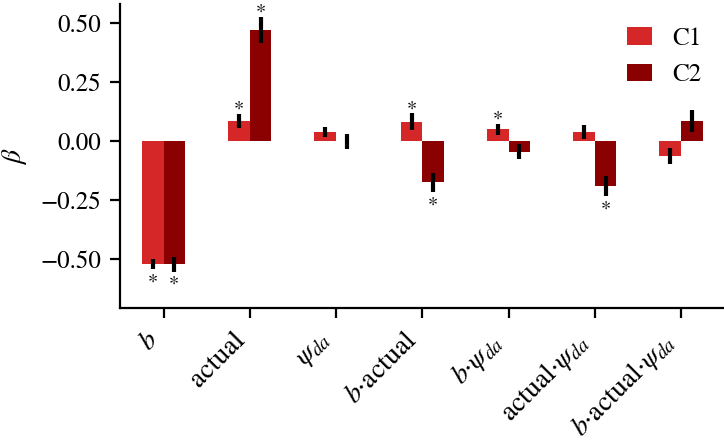

In [12]:
# perform regression
nt = 'da'

cols = ['bet','actual', nt]

poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
baselines = []

for i, data in enumerate([all_data0, all_data1]):
    dat = data.copy()
    result = run_model(dat, dep_var='d_bet', regressors=cols, criterion=criterion_dbet)
    basline_cols = cols.copy()
    basline_cols.remove(nt)
    baseline_result = run_model(dat, dep_var='d_bet', regressors=basline_cols, criterion=criterion_dbet)
    baselines.append(baseline_result.llf)

coeffs = []
errs = []
p_vals = []
ll = []

for j, cluster_data in enumerate([all_data0, all_data1]):

    data = cluster_data.copy()
    result = run_model(data, dep_var='d_bet', regressors=cols, criterion=criterion_dbet)

    coeffs.append(result.params)
    errs.append(result.bse)
    p_vals.append(result.pvalues.values)
    ll.append(result.llf)
    
    print('Cluster ' + str(j+1))
    print('BIC: %.2f' % (result.bic)) 
    print('LL: %d \n' % ( result.llf)) 
    
# plot results
fig, ax = plt.subplots(1, 1, figsize=(2*figwidth/3,2.5), dpi=200, sharey=True, sharex=True)
pd.DataFrame({'C1': coeffs[0], 'C2': coeffs[1]}).plot(kind='bar', width=.5, ax=ax, color=color, yerr=errs, rot=45).legend(loc='upper right', frameon=False, handlelength=1)
ax.set_ylabel(r'$\beta$')

labels = []
for label in ax.get_xticklabels():
    text = label.get_text()
    text = text.replace(nt, '$\psi_{%s}$' % nt)
    text = text.replace('bet', '$b$')
    text = text.replace('*', '$\cdot$')
    label.set_text(text)
    labels.append(label)
ax.set_xticklabels(labels, ha='right', fontsize=10)
    
for j, (p_val, coeff, err) in enumerate(zip(p_vals, coeffs, errs)):
    for x, (p, c, e) in enumerate(zip(p_val, coeff, err)):
        if p<0.05:
            y_pos = c + np.sign(c)*e
            if np.sign(c)>0:
                va = 'bottom'
            else:
                va='top'
            ax.text(x+(j*2-1)*0.125, y_pos, '\u2217', ha='center', va=va, fontsize=7)
ax.set_ylim(ax.get_ylim()[0]-.1)
            
plt.tight_layout()
plt.savefig('figures/'+nt+'_predicts_dbet.pdf')
plt.savefig('figures/'+nt+'_predicts_dbet.png')

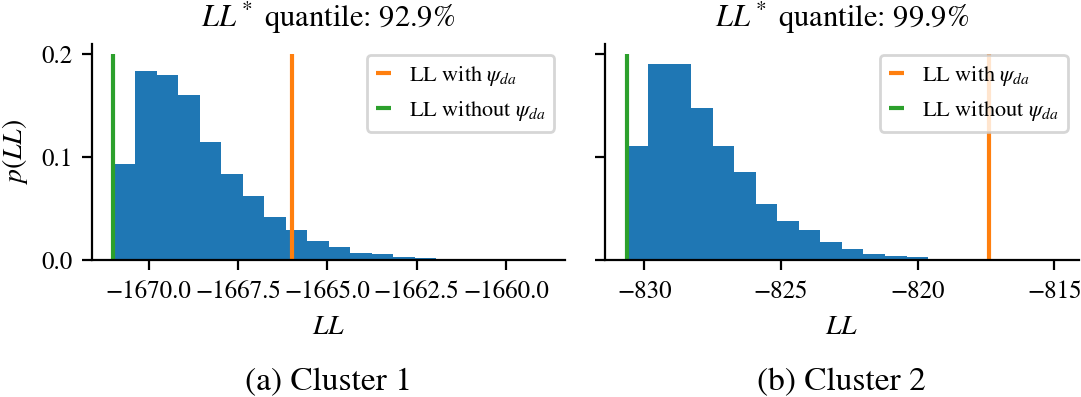

In [14]:
# permute nmod and check for significance
n_perms = 10000
lls = []
for i, data in enumerate([all_data0, all_data1]):
    dat = data.copy()
    lls.append(shuffle_column(dat, regressors=cols, dep_var='d_bet', shuffle_column=nt, n=n_perms, criterion=criterion_dbet))  

fig, ax = plt.subplots(1,2,figsize=(figwidth,2), dpi=200, sharey=True)
for i, (ll_, lls_, baseline) in enumerate(zip(ll, lls, baselines)):
    
    ax[i].hist(lls_, bins=20, weights=np.ones(len(lls_))/len(lls_))
    ax[i].vlines(ll_, 0,.2, 'tab:orange', label='LL with $\psi_{da}$')
    ax[i].vlines(baseline, 0,.2, 'tab:green', label='LL without $\psi_{da}$')
    ax[i].set_title('$LL^*$ quantile: %.1f%%' % (100* ((lls_<ll_).sum()/len(lls_))))
    ax[i].legend(fontsize=8,handlelength=.7)
#     ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45,)
    ax[i].set_xlabel('$LL$')

    
ax[0].set_ylabel('$p(LL)$')
plt.tight_layout()
ax[0].text(0.5, -.6, '(a) Cluster 1', ha='center', fontsize=12,transform=ax[0].transAxes)
ax[1].text(0.5, -.6, '(b) Cluster 2', ha='center', fontsize=12,transform=ax[1].transAxes)

plt.savefig('figures/'+nt+'_predicts_dbet_quantiles.pdf')
plt.savefig('figures/'+nt+'_predicts_dbet_quantiles.png')

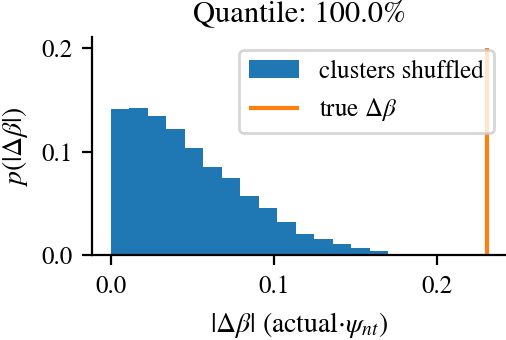

In [35]:
# permuting clusters
coeffs0 = []
coeffs1 = []
shuffle_coeffs = [coeffs0, coeffs1]

errs0 = []
errs1 = []
errs = [errs0, errs1]

p_vals0 = []
p_vals1 = []
p_vals = [p_vals0, p_vals1]

n_permutations = 10000

for perm in range(n_permutations):
    
    all_data_ = all_data.copy()
    all_data_['cluster'] = np.random.permutation(all_data_['cluster'])
    
    all_data0_ = all_data_[all_data_['cluster']==0]
    all_data0_.index = np.arange(len(all_data0_))

    all_data1_ = all_data_[all_data_['cluster']==1]
    all_data1_.index = np.arange(len(all_data1_))
    
    for j, (cluster_data, coeff, err, p_val)  in enumerate(zip([all_data0_, all_data1_], shuffle_coeffs, errs, p_vals)):

        data = cluster_data.copy()
        result = run_model(data, dep_var='d_bet', regressors=cols, criterion=criterion_dbet)

        coeff.append(result.params)
        err.append(result.bse)
        p_val.append(result.pvalues.values)

shuffle_coeffs = [pd.DataFrame(shuffle_coeffs[0]), pd.DataFrame(shuffle_coeffs[1])]

var = 'actual*da'


fig, ax = plt.subplots(figsize=(figwidth/2,2), dpi=200)
coeff_diff = (coeffs[0][var]-coeffs[1][var])

shuffle_coeffs_diffs  = abs(shuffle_coeffs[0][var]-shuffle_coeffs[1][var])

ax.hist(shuffle_coeffs_diffs, bins=20, weights=np.ones(len(shuffle_coeffs_diffs))/len(shuffle_coeffs_diffs), label='clusters shuffled')
ax.vlines(coeff_diff, 0,.2, 'tab:orange',  label=r'true $\Delta \beta$')


quantile = 100* (shuffle_coeffs_diffs<coeff_diff).sum()/len(shuffle_coeffs_diffs)

ax.set_title('Quantile: %.1f%%' % quantile)
ax.legend()
ax.set_xlabel(r'$|\Delta \beta|$ (%s)' % var.replace(nt, '$\psi_{nt}$').replace('*','$\cdot$'))
ax.set_ylabel(r'$p(|\Delta \beta|)$')
plt.tight_layout()
plt.savefig('figures/'+nt+'_predicts_dbet_quantiles_cluster_shuffle.pdf')
plt.savefig('figures/'+nt+'_predicts_dbet_quantiles_cluster_shuffle.png')

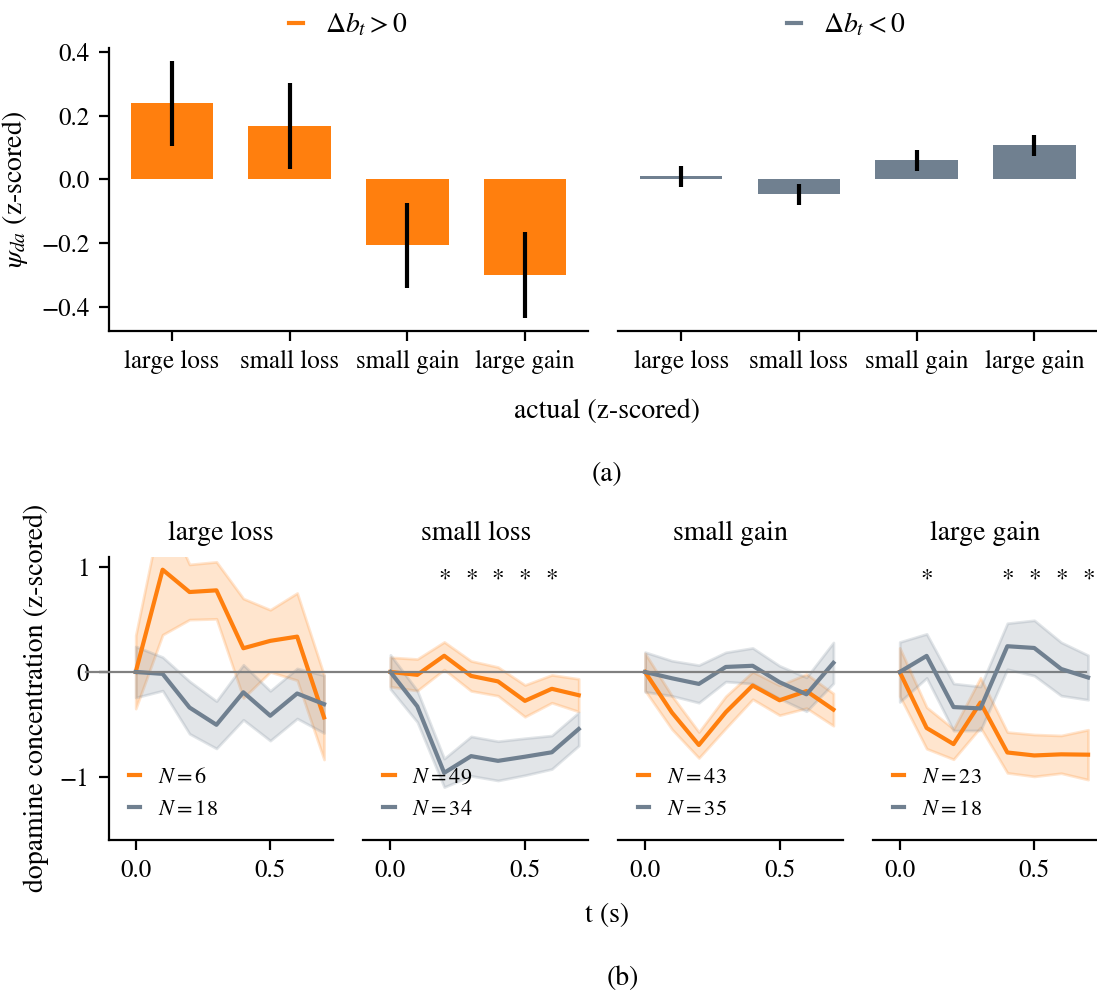

In [15]:
# investigate significant predictor 'actual*da' for \delta bet in cluster 2 

x = np.linspace(-30,30,61)/10
xlim = [0,.7]
x_plot = x[np.argmin(abs(x-xlim[0])):np.argmin(abs(x-xlim[1]))+1]
plt_colors = ['tab:orange', 'slategrey']

bin_var = 'actual'
dep_var= 'd_bet'
nt = 'da'
cluster=1

titles = ['large loss', 'small loss', 'small gain', 'large gain']

n_bins = 4

data = all_data1.dropna()
bins = np.linspace(np.quantile(data[bin_var],.05), np.quantile(data[bin_var],.95), n_bins+1)

behav_data = utils.load_data_patient('all')
neural_data =  utils.load_data_neural('all', neurotransmitter=nt, event='reveal')

fig = plt.figure(figsize=(figwidth,4.5), dpi=200)

gs = mpl.gridspec.GridSpec(2, n_bins)


for plt_i, dep_cond in enumerate([data[dep_var]>0,data[dep_var]<0]):
    if plt_i==1:
        ax = fig.add_subplot(gs[0, plt_i*2:(plt_i*2)+2], sharey=ax)
        ax.get_yaxis().set_visible(False)
        ax.spines['left'].set_visible(False)
    else:
        ax = fig.add_subplot(gs[0, plt_i*2:(plt_i*2)+2])

    freqs = np.zeros(n_bins)
    errs = np.zeros(n_bins)
    n = np.zeros(n_bins)
    

    for i in range(n_bins):
        cond = (data[bin_var]>bins[i]) & (data[bin_var]<= bins[i+1]) & (dep_cond)
        freqs[i] = data[nt][cond].mean()
        errs[i] = data[nt][cond].sem()
        n[i] = len(data[nt][cond])
    
    bar = ax.bar((bins[:-1]+bins[1:])/2, freqs, width=np.diff(bins)[0]*.7, align='center', color=plt_colors[plt_i], yerr=sem(freqs))

    if plt_i == 0:
        ax.set_ylabel('$\psi_{da}$ (z-scored)')
    
    ax.set_xticks((bins[:-1]+bins[1:])/2)
    ax.set_xticklabels(titles)
        
fig.text(.55,.48, '(a)', fontsize=fontsize, ha='center')
fig.text(.55, .55, bin_var + ' (z-scored)', ha='center')


for i in range(n_bins):
    if i ==0:
        axs = fig.add_subplot(gs[1, i])
    else:
        axs = fig.add_subplot(gs[1, i], sharey=axs, sharex=axs)
                       
    pos = np.empty((0,61))
    neg = np.empty((0,61))

    for s, (neural, behav) in enumerate(zip(neural_data, behav_data)):
        if not preds[s]==cluster:
            continue
        crit1 = neural[:len(behav)][(behav[dep_var]>0) & (behav[bin_var]>bins[i]) & (behav[bin_var]<= bins[i+1])]
        crit2 = neural[:len(behav)][(behav[dep_var]<0) & (behav[bin_var]>bins[i]) & (behav[bin_var]<= bins[i+1])]
        pos = np.vstack((pos, crit1))
        neg = np.vstack((neg, crit2))

    pos = pos[~np.any(np.isnan(pos),axis=1)]
    neg = neg[~np.any(np.isnan(neg),axis=1)]

    signif_dat = []
    for dat, dat_type, col in zip([pos, neg], ['pos', 'neg'], plt_colors):
        if len(dat)==0:
            continue

        dat = dat[:, np.argmin(abs(x-xlim[0])):np.argmin(abs(x-xlim[1]))+1]
        standard_dat = zscore(dat, axis=1)
        mean_dat = np.nanmean(standard_dat, axis=0)-np.nanmean(standard_dat[:,np.argwhere(x_plot==0)])
        sem_dat = sem(standard_dat, axis=0)

        axs.plot(x_plot,mean_dat, col, label='$N=%d$' % len(dat))
        axs.fill_between(x_plot, mean_dat-sem_dat, mean_dat+sem_dat, alpha=.2, color=col, label=None)

        dat_ = standard_dat-np.nanmean(standard_dat[:,np.argwhere(x_plot==0)])
        signif_dat.append(dat_)


    axs.legend(fontsize=8, loc='lower left', frameon=False, handlelength=.5)

    if len(signif_dat) == 2:
        signif = ttest_ind(signif_dat[0],signif_dat[1])[1]
        signif_corr= fdrcorrection(signif)[0]

        for x_sig in x_plot[signif_corr]:
            axs.text(x_sig, 1, '*',va='top', ha='center', fontsize=9)  

    axs.set_title(titles[i], fontsize=10)
    axs.set_ylim(-1.6,1.1)

    if i == 0:
        axs.set_ylabel('dopamine concentration (z-scored)')
    else:
        axs.get_yaxis().set_visible(False)
        axs.spines['left'].set_visible(False)

    if i == n_bins-1:
        axs.axhline(y=0, xmin=-3.5, xmax=.95, c="gray", linewidth=.8, zorder=-1, clip_on=False)

plt.xlim(-0.1)
fig.text(.55,-.01, 't (s)', fontsize=fontsize, ha='center')
fig.text(.55, -.08, '(b)')

handles, labels = plt.gca().get_legend_handles_labels()





fig.legend(handles[:1], ['$\Delta b_{t} > 0$'], fontsize=10, frameon=False, bbox_to_anchor=(0.4,1.03), handlelength=.5)
fig.legend(handles[1:], ['$\Delta b_{t} < 0$'], fontsize=10, frameon=False, bbox_to_anchor=(0.83,1.03), handlelength=.5)

plt.tight_layout()
fig.subplots_adjust(hspace=.8) 
plt.savefig('figures/'+nt+'_predicts_dbet_traces.pdf')
plt.savefig('figures/'+nt+'_predicts_dbet_traces.png')

# Stepwise regression (not in thesis)

1.0
0.85


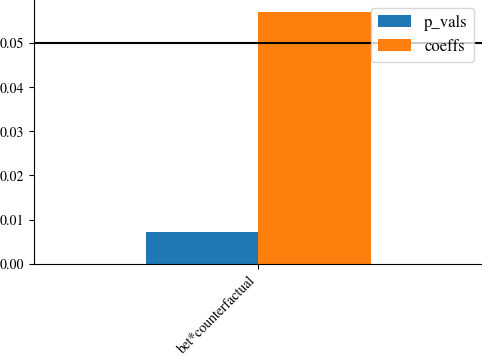

In [775]:
# stepwise regression
cols = ['bet', 'actual','counterfactual','d_market_belief', 'regret', 'rejoice', 'counterfactual_regret', 'counterfactual_rejoice']
nt='da'
cluster = 0

if cluster == 0:
    data = all_data0.copy()
else:
    data = all_data1.copy()
    
data['sign_d'] = np.sign(data['actual'])
poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
Xb = data[cols]
y_true = data[nt].values
X_tr = poly.fit_transform(Xb)
cs = poly.get_feature_names()

for i, c in enumerate(cs[:len(cols)]):
    cs = [x.replace(c, cols[i]) for x in cs]
    cs = [x.replace(' ', '*') for x in cs]
    rel_cs = [x for x in cs if criterion_nt(x)]

Xt = pd.DataFrame(X_tr,columns=cs)[rel_cs]
test_cols = list(Xt.columns)



take_cols = []
last_ll = -np.inf
Xt[nt] = data[nt]

for i in range(3):
    
    best_ll = -np.inf
    
    for col in test_cols:
        
        result = run_model(Xt.copy(), dep_var=nt, regressors=take_cols + [col], criterion=criterion_nt, degree=1)

        if result.llf > best_ll:
            take_col = col
            best_ll = result.llf
            result_ = result
        
    shuffle_lls = shuffle_column(Xt.copy(), dep_var=nt, regressors=take_cols + [take_col], shuffle_column=take_col, criterion=criterion_nt, degree=1, n=100)
    percentile = (best_ll>shuffle_lls).sum()/len(shuffle_lls)
    print(percentile)
    
    if i >0:
        if percentile <.95:
            break

    take_cols.append(take_col)
    test_cols.remove(take_col)
    best_result = result_
    last_ll = best_ll
    

fig, ax = plt.subplots(figsize=(figwidth,3.5),dpi=100)
pd.DataFrame([best_result.pvalues, best_result.params],index=['p_vals', 'coeffs']).T.plot(kind='bar', ax=ax)

plt.xticks(rotation=45, ha='right')
plt.hlines(0.05,-.5,len(cs)-.5,'k')